# PROJETO ANÁLISE - WEB SCRAPING - STEAM

## Descrição do objetivo do projeto


Jogadores e desenvolvedores de jogos muitas vezes têm dificuldade em identificar quais gêneros, estilos ou títulos estão em alta ou caindo em popularidade. Uma fonte poderosa desse tipo de informação é justamente o site da Steam, onde é possível descobrir:

- Quais são os jogos que mais estão em alta (maior publicidade do jogo no site)

- Quais são os jogos mais vendidos no momento em cada país 

- Quais são os gêneros de jogos mais recorrentes no ranking global

In [1]:
# !python3 -m pip install BeautifulSoup4==4.13.3
# !python3 -m pip install scikit-learn==1.6.1
# !python3 -m pip install selenium==4.29.0
# !python3 -m pip install webdriver_manager

## Etapas de execução do projeto

1) <a href="#carrossel">Captura dos jogos do carrossel do site</a>

2) <a href="#jogos_mais_vendidos_por_pais">Captura dos jogos mais vendidos por país: Mapa de Calor</a>

3) <a href="#precos_e_ofertas">Captura dos gêneros, preços e ofertas de jogos</a>

4) <a href="#generos_recorrencia">Identificando gêneros mais recorrentes: Wordcloud</a>

5) <a href="#analise_llm">API do Gemini: Adivinhação dos gêneros a partir da descrição</a>

## Instalando as dependências

In [160]:
# Imports necessários
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from functions import *
import pprint
import time
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import random

## Testes das funções auxiliares elaboradas: captura de gêneros 

In [3]:
# Testando funcionamento da função baixar página para um jogo qualquer
url = "https://store.steampowered.com/app/570940/DARK_SOULS_REMASTERED/"
pagina = baixar_pagina(url)

lista_generos = []
# Testando funcionamento da função extrair gênero para o mesmo jogo qualquer
extrair_genero(pagina, lista_generos)

['Souls-like',
 'Dark Fantasy',
 'RPG',
 'Difficult',
 'Action',
 'Dark',
 'Fantasy',
 'Atmospheric',
 'Great Soundtrack',
 'Action RPG',
 'Lore-Rich',
 'Adventure',
 'Multiplayer',
 'Exploration',
 'Story Rich',
 'Third Person',
 'Replay Value',
 'Character Customization',
 'Soundtrack',
 'Co-op']

## Inicializando o driver do Selenium

In [159]:
try:
    driver.quit()
    print('Fechando o driver')
except Exception as e:
    pass

print('Inicializando o driver')

# Inicializa o driver do Selenium
chrome_options = webdriver.ChromeOptions()
# chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
driver.set_page_load_timeout(60)

Fechando o driver
Inicializando o driver


## <div id="carrossel">Pega informação dos jogos do carrossel principal - "Destaque"</div>

In [161]:
# Pega pagina inicial da Steam
url = "https://store.steampowered.com/"
driver.get(url)
driver.implicitly_wait(10)

In [6]:
# Inicializa o Beautiful Soup
soup = BeautifulSoup(driver.page_source, 'html.parser')

carousel_items = {}

all_carousel = soup.find_all('a', class_="store_main_capsule")

g_id = 0
for game in all_carousel:
    g_name = game.find('div', class_="app_name").text
    g_reason = game.find('div', class_="reason").text
    href = game['href']

    carousel_items[g_id] = {
        'name': g_name,
        'page': href,
    }

    g_id += 1

pprint.pp(carousel_items)

{0: {'name': 'Stellar Blade™',
     'page': 'https://store.steampowered.com/app/3489700/Stellar_Blade/?snr=1_4_4__129_1'},
 1: {'name': 'Clair Obscur: Expedition 33',
     'page': 'https://store.steampowered.com/app/1903340/Clair_Obscur_Expedition_33/?snr=1_4_4__129_2'},
 2: {'name': 'The Elder Scrolls® Online',
     'page': 'https://store.steampowered.com/app/306130/The_Elder_Scrolls_Online/?snr=1_4_4__129_3'},
 3: {'name': 'The Last of Us™ Part II Remastered',
     'page': 'https://store.steampowered.com/app/2531310/The_Last_of_Us_Part_II_Remastered/?snr=1_4_4__129_4'},
 4: {'name': 'MLB Rivals',
     'page': 'https://store.steampowered.com/app/2569510/MLB_Rivals/?snr=1_4_4__129_5'},
 5: {'name': "Tom Clancy's Rainbow Six® Siege",
     'page': 'https://store.steampowered.com/app/359550/Tom_Clancys_Rainbow_Six_Siege/?snr=1_4_4__129_6'},
 6: {'name': 'Path of Exile 2',
     'page': 'https://store.steampowered.com/app/2694490/Path_of_Exile_2/?snr=1_4_4__129_7'},
 7: {'name': 'Red Dead R

In [7]:
# Transforma o dicionário em DataFrame
df_carrossel = pd.DataFrame.from_dict(carousel_items, orient='index')
df_carrossel.reset_index(drop=True, inplace=True)
df_carrossel.rename(columns={"name": "Jogo", "page": "Link", "status": "Disponibilidade"}, inplace=True)
df_carrossel

,Jogo,Link
0,Stellar Blade™,https://store.steampowered.com/app/3489700/Ste...
1,Clair Obscur: Expedition 33,https://store.steampowered.com/app/1903340/Cla...
2,The Elder Scrolls® Online,https://store.steampowered.com/app/306130/The_...
3,The Last of Us™ Part II Remastered,https://store.steampowered.com/app/2531310/The...
4,MLB Rivals,https://store.steampowered.com/app/2569510/MLB...
5,Tom Clancy's Rainbow Six® Siege,https://store.steampowered.com/app/359550/Tom_...
6,Path of Exile 2,https://store.steampowered.com/app/2694490/Pat...
7,Red Dead Redemption 2,https://store.steampowered.com/app/1174180/Red...
8,Diablo® IV,https://store.steampowered.com/app/2344520/Dia...
9,ELDEN RING,https://store.steampowered.com/app/1245620/ELD...


## <div id="jogos_mais_vendidos_por_pais">Pega informação dos jogos mais vendidos por país</div>

In [162]:
# Pega pagina de jogos mais vendidos globalmente da Steam
url_mais_vendidos_global = "https://store.steampowered.com/charts/topselling/global"
driver.get(url_mais_vendidos_global)
driver.implicitly_wait(10)

In [165]:
# Testando captura dos jogos apenas para o ranking global
soup = BeautifulSoup(driver.page_source, 'html.parser')

top15_global = {}

all_games = soup.find_all('div', class_="_1n_4-zvf0n4aqGEksbgW9N")

limite = 15
for i, game in enumerate(all_games[:limite]):
    top15_global[i] = game.text
top15_global

{0: 'Counter-Strike 2',
 1: 'ELDEN RING NIGHTREIGN',
 2: 'Steam Deck',
 3: 'Stellar Blade™',
 4: 'Dune: Awakening',
 5: 'F1® 25',
 6: 'Clair Obscur: Expedition 33',
 7: 'The Elder Scrolls IV: Oblivion Remastered',
 8: 'FANTASY LIFE i: The Girl Who Steals Time',
 9: 'Red Dead Redemption 2',
 10: 'HELLDIVERS™ 2',
 11: 'The Elder Scrolls® Online',
 12: 'Apex Legends™',
 13: 'Marvel Rivals',
 14: 'POPUCOM'}

In [10]:
siglas_paises = {
    'Global': 'global', 
    'Alemanha': 'DE',
    'Austrália': 'AU',
    'Brasil': 'BR',
    'Bélgica': 'BE',
    'Canadá': 'CA',
    'China': 'CN',
    'Coreia do Sul': 'KR',
    'Dinamarca': 'DK',
    'Espanha': 'ES',
    'Estados Unidos': 'US',
    'Rússia': 'RU',
    'Finlândia': 'FI',
    'França': 'FR',
    'Hong Kong': 'HK',
    'Itália': 'IT',
    'Japão': 'JP',
    'Noruega': 'NO',
    'Nova Zelândia': 'NZ',
    'Países Baixos': 'NL',
    'Polônia': 'PL',
    'Reino Unido': 'GB',
    'República Tcheca': 'CZ',
    'Singapura': 'SG',
    'Suécia': 'SE',
    'Suíça': 'CH',
    'Tailândia': 'TH',
    'Taiwan': 'TW',
    'Turquia': 'TR',
    'Áustria': 'AT'
}

top15_por_pais = {}

for pais, sigla in siglas_paises.items():
    # print(f'Lendo página: {pais}')
    url_pais = f"https://store.steampowered.com/charts/topselling/{sigla}"
    driver.get(url_pais)    
    driver.implicitly_wait(10)

    time.sleep(1.7)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    all_games = soup.find_all('div', class_="_1n_4-zvf0n4aqGEksbgW9N")

    limite = 15
    dict_pais = {}
    for i, game in enumerate(all_games[:limite]):
        dict_pais[i] = game.text
        
    top15_por_pais[pais] = dict_pais

top15_por_pais

{'Global': {0: 'Counter-Strike 2',
  1: 'ELDEN RING NIGHTREIGN',
  2: 'Steam Deck',
  3: 'Stellar Blade™',
  4: 'Dune: Awakening',
  5: 'F1® 25',
  6: 'Clair Obscur: Expedition 33',
  7: 'The Elder Scrolls IV: Oblivion Remastered',
  8: 'FANTASY LIFE i: The Girl Who Steals Time',
  9: 'Red Dead Redemption 2',
  10: 'The Elder Scrolls® Online',
  11: 'POPUCOM',
  12: 'Sekiro™: Shadows Die Twice - GOTY Edition',
  13: 'The Last of Us™ Part I',
  14: 'HELLDIVERS™ 2'},
 'Alemanha': {0: 'ELDEN RING NIGHTREIGN',
  1: 'Counter-Strike 2',
  2: 'Steam Deck',
  3: 'Dune: Awakening',
  4: 'F1® 25',
  5: 'The Elder Scrolls IV: Oblivion Remastered',
  6: 'Stellar Blade™',
  7: 'The Elder Scrolls® Online',
  8: 'Clair Obscur: Expedition 33',
  9: 'Tainted Grail: The Fall of Avalon',
  10: 'RoadCraft',
  11: 'War Thunder',
  12: 'Schedule I',
  13: 'Tom Clancy’s The Division® 2',
  14: '9 Kings'},
 'Austrália': {0: 'Counter-Strike 2',
  1: 'ELDEN RING NIGHTREIGN',
  2: 'Steam Deck',
  3: 'Dune: Awake

In [11]:
# Verifica se algum pais ficou com jogos a menos
for pais, jogos in top15_por_pais.items():
    if len(jogos) < 15:
        print(f'Erro na leitura de: {pais}')

In [12]:
# Montando dataframe a partir do scraping feito
df_ranking = pd.DataFrame.from_dict(top15_por_pais, orient='index').transpose()
df_ranking['Ranking'] = [i for i in range(1, 16)]
cols = ['Ranking'] + [col for col in df_ranking.columns if col != 'Ranking']
df_ranking = df_ranking[cols]
df_ranking.head(3)

,Ranking,Global,Alemanha,Austrália,Brasil,Bélgica,Canadá,China,Coreia do Sul,Dinamarca,...,Polônia,Reino Unido,República Tcheca,Singapura,Suécia,Suíça,Tailândia,Taiwan,Turquia,Áustria
0,1,Counter-Strike 2,ELDEN RING NIGHTREIGN,Counter-Strike 2,Counter-Strike 2,Steam Deck,Steam Deck,Counter-Strike 2,Stellar Blade™,Counter-Strike 2,...,Counter-Strike 2,Steam Deck,Counter-Strike 2,Counter-Strike 2,Counter-Strike 2,Counter-Strike 2,ELDEN RING NIGHTREIGN,Stellar Blade™,Counter-Strike 2,Counter-Strike 2
1,2,ELDEN RING NIGHTREIGN,Counter-Strike 2,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,Stellar Blade™,PUBG: BATTLEGROUNDS,ELDEN RING NIGHTREIGN,...,ELDEN RING NIGHTREIGN,Counter-Strike 2,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,Counter-Strike 2,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN,ELDEN RING NIGHTREIGN
2,3,Steam Deck,Steam Deck,Steam Deck,Red Dead Redemption 2,F1® 25,Counter-Strike 2,POPUCOM,ELDEN RING NIGHTREIGN,Dune: Awakening,...,Steam Deck,ELDEN RING NIGHTREIGN,Steam Deck,Dota 2,Steam Deck,F1® 25,Stellar Blade™,Counter-Strike 2,REMATCH,F1® 25


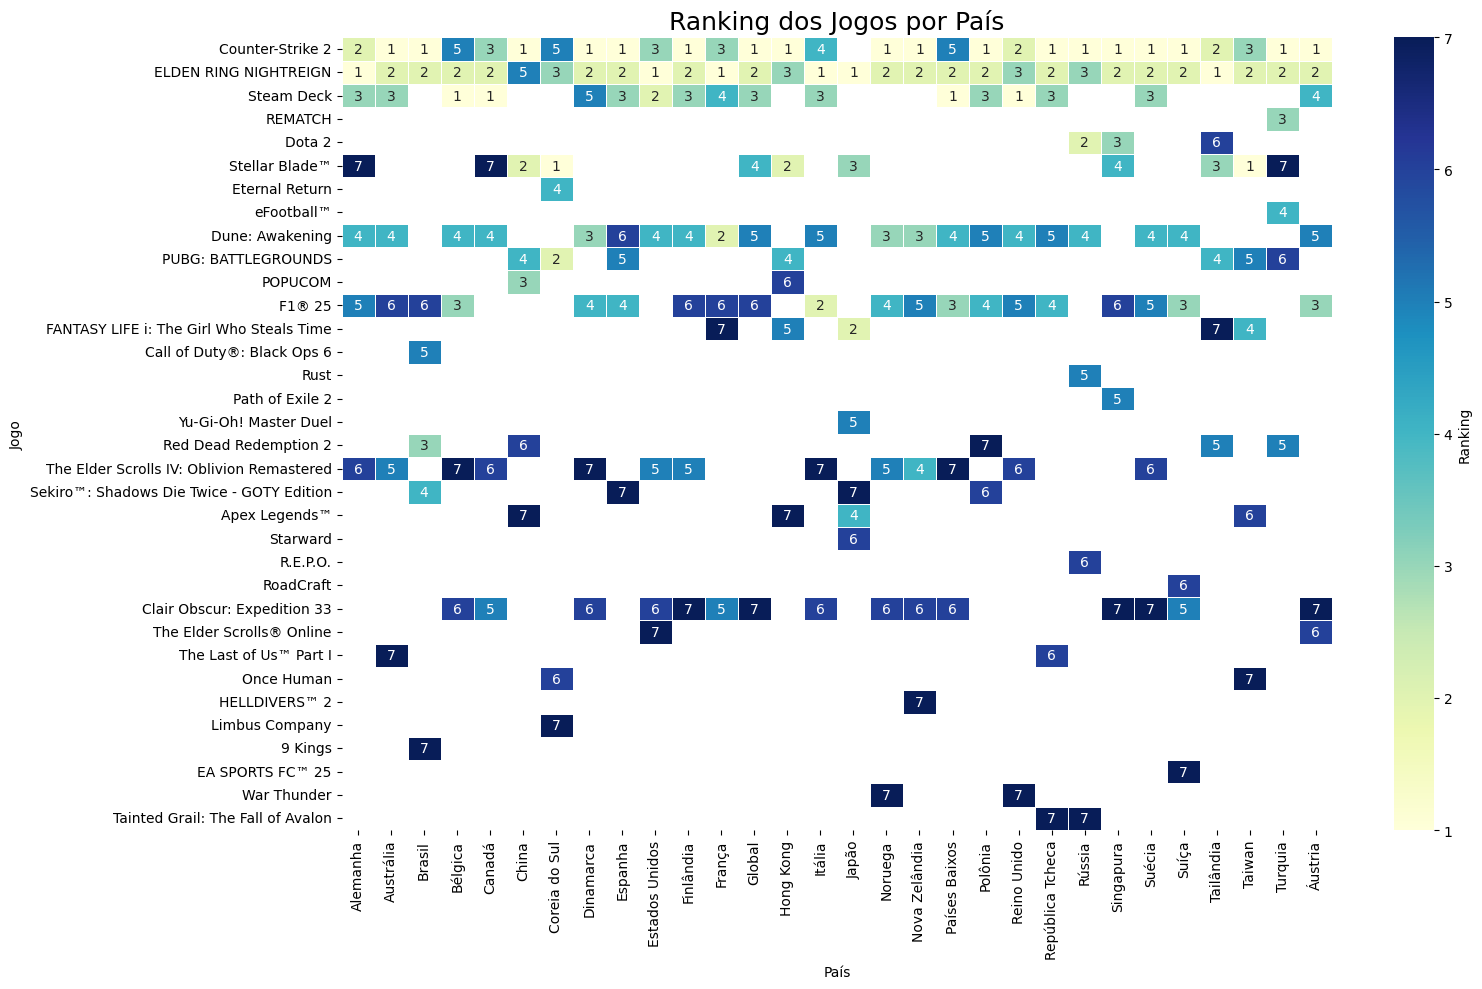

In [13]:
df_top7 = df_ranking.iloc[:7, :] 

if 'Ranking' in df_top7.columns:
    df_top7 = df_top7.drop(columns=['Ranking'])

df_top7_long = df_top7.melt(var_name='País', value_name='Jogo')

df_top7_long['Ranking'] = df_top7_long.groupby('País').cumcount() + 1

heatmap_data = df_top7_long.pivot_table(index='Jogo', columns='País', values='Ranking')

heatmap_data['Média'] = heatmap_data.mean(axis=1)
heatmap_data = heatmap_data.sort_values('Média')
heatmap_data = heatmap_data.drop(columns='Média')

plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Ranking'})

plt.title('Ranking dos Jogos por País', fontsize=18)
plt.xlabel('País')
plt.ylabel('Jogo')
plt.tight_layout()
plt.show()

## Análise do Heat Map:

O mapa de calor apresentado permite identificar alguns padrões relevantes no comportamento do mercado de games entre diferentes países:

- CS-2 mantém sua liderança de forma consistente em diversos mercados. O jogo figura como o título mais vendido na maioria dos países, consolidando-se como um sucesso global e um dos pilares do cenário competitivo atual.

- Elden Ring apresenta uma forte adesão global, reflexo do recente lançamento da sua expansão. O jogo aparece no top 3 da maioria dos países, indicando uma recepção extremamente positiva e uma demanda elevada, tanto de jogadores veteranos quanto de novos entrantes.

- Presença de títulos com popularidade regional: alguns jogos aparecem no ranking de apenas um país, o que pode refletir tanto tendências locais quanto afinidade cultural ou apoio à indústria nacional.

    Exemplos:

    - 9 Kings, desenvolvido no Brasil, figura entre os mais vendidos no próprio país.

    - Limbus Company, da desenvolvedora sul-coreana Project Moon, tem destaque relevante na Coreia do Sul.

    - Outros títulos, como COD 2, Rust e Helldivers 2, também apresentam aparições isoladas, possivelmente impulsionados por fatores regionais, promoções específicas ou afinidade do público local.

- Potencial influência do país de origem dos desenvolvedores: A coincidência entre o local de desenvolvimento de alguns jogos e sua popularidade nos rankings nacionais sugere que, além da qualidade do jogo, há um efeito de identificação cultural e apoio à indústria local.

## <div id="precos_e_ofertas">Pega gêneros, preços e ofertas dos jogos - Top 15 global</div>

In [14]:
url_pais = f"https://store.steampowered.com/charts/topselling/global"
driver.get(url_pais)
driver.implicitly_wait(10)

botoes_jogos = driver.find_elements(By.CLASS_NAME, "_2-RN6nWOY56sNmcDHu069P")
jogos_generos = {}
lista_generos = []

count = 0
for i, _ in enumerate(botoes_jogos[:limite]):
    # if count == 5: 
    #     break

    time.sleep(2)
    botoes_jogos = driver.find_elements(By.CLASS_NAME, "_2-RN6nWOY56sNmcDHu069P")
    botoes_jogos[i].click()
    time.sleep(2)

    driver.implicitly_wait(10)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    # print(driver.current_url)

    if 'steamdeck' not in driver.current_url.split('/'):
        pagina = baixar_pagina(driver.current_url)
        top5_generos = extrair_genero(pagina, lista_generos)[0:4]

        # Automatiza colocar uma data de nascimento valida
        # Para jogos +18
        try:
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            nome_jogo = soup.find('div', class_="apphub_AppName").text
        except Exception as e:
            # Insere data valida (1996)
            botao_1996 = driver.find_element(By.XPATH, '//*[@id="ageYear"]/option[97]')
            botao_1996.click()
            # Entra na pagina
            botao_ViewPage = driver.find_element(By.XPATH, '//*[@id="view_product_page_btn"]/span')
            botao_ViewPage.click()
            time.sleep(1)
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            nome_jogo = soup.find('div', class_="apphub_AppName").text

        try:
            price = soup.find('div', class_="price").text.strip()
        except:
            price == soup.find('div', class_="discount_final_price").text.strip()

        # Verifica se tem está com desconto
        try:
            offer = soup.find('div', class_="discount_pct")
        except:
            pass

        status_offer = 1 if offer and price != "Gratuitos para Jogar" else 0
        # print(nome_jogo)
        # print(top5_generos)
        # print(f'   Preço: {price}')
        # print(f'   Status Offer: {status_offer}')
        # print()
        jogos_generos[nome_jogo] = {}
        jogos_generos[nome_jogo]["gêneros"] = top5_generos
        jogos_generos[nome_jogo]["preco"] = price
        jogos_generos[nome_jogo]["status_offer"] = status_offer
    else:
        count -= 1

    lista_generos = []
    top5_generos = []
    count += 1
    
    url_pais = f"https://store.steampowered.com/charts/topselling/global"
    driver.get(url_pais)
    driver.implicitly_wait(10)

In [15]:
# Jogos, gêneros, preços e ofertas para dataframe
jogos_generos_top15 = {k: v['gêneros'] for k, v in jogos_generos.items() if len(v['gêneros']) > 0}
jogo_preco_status = {k: {'preco': v['preco'], 'status_offer': v['status_offer']} for k, v in jogos_generos.items() if len(v['gêneros']) > 0}
# Cria dataframe com os gêneros e preços dos jogos
df_jogos_top15 = pd.DataFrame.from_dict(jogos_generos_top15, orient='index').reset_index()
df_jogos_top15.columns = ['Jogo'] + [f'Gênero {i+1}' for i in range(df_jogos_top15.shape[1] - 1)]
# Preço e status de oferta
df_jogos_top15['Preço'] = [jogo_preco_status[jogo]['preco'] for jogo in df_jogos_top15['Jogo']]
df_jogos_top15['Status Oferta'] = [jogo_preco_status[jogo]['status_offer'] for jogo in df_jogos_top15['Jogo']]

In [16]:
df_jogos_top15

,Jogo,Gênero 1,Gênero 2,Gênero 3,Gênero 4,Preço,Status Oferta
0,Counter-Strike 2,FPS,Shooter,Multiplayer,Competitive,Free To Play,1
1,ELDEN RING NIGHTREIGN,Souls-like,Online Co-Op,Roguelike,Multiplayer,"R$ 197,90",0
2,Dune: Awakening,Open World Survival Craft,Adventure,Third Person,Massively Multiplayer,"R$ 179,00",0
3,F1® 25,Racing,Sports,Simulation,PvP,"R$ 249,00",0
4,Clair Obscur: Expedition 33,Turn-Based Combat,Story Rich,Fantasy,RPG,"R$ 199,00",0
5,The Elder Scrolls IV: Oblivion Remastered,RPG,Open World,Fantasy,Singleplayer,"R$ 45,81",1
6,Marvel Rivals,Free to Play,Multiplayer,Hero Shooter,Third-Person Shooter,Free To Play,0
7,FANTASY LIFE i: The Girl Who Steals Time,RPG,Action,Casual,JRPG,"R$ 299,90",0
8,HELLDIVERS™ 2,Online Co-Op,PvE,Third-Person Shooter,Multiplayer,"R$ 199,50",0
9,Apex Legends™,Free to Play,Battle Royale,Multiplayer,FPS,Free To Play,0


## <div id="generos_recorrencia">Identificando os gêneros mais recorrentes</div>

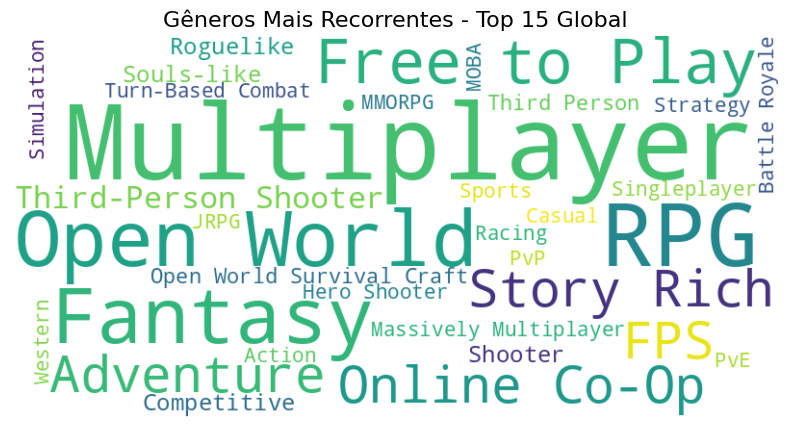

In [17]:
def gerar_wordcloud_generos(df, titulo):
    colunas_genero = ['Gênero 1', 'Gênero 2', 'Gênero 3', 'Gênero 4']
    
    generos = df[colunas_genero].values.flatten()
    generos = [g for g in generos if g not in [None, 'None']]
    
    contador = Counter(generos)
    
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
    wc.generate_from_frequencies(contador)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=16)
    plt.show()

gerar_wordcloud_generos(df_jogos_top15, "Gêneros Mais Recorrentes - Top 15 Global")

## Análise da Wordcloud:

A wordcloud evidencia de forma clara quais são os gêneros que dominam a preferência dos jogadores globalmente:

- Domínio de jogos multiplayer: O termo "Multiplayer" aparece com destaque absoluto, seguido de gêneros que reforçam interações online como "Online Co-Op" e "Massively Multiplayer". Isso reflete uma forte preferência global por experiências sociais e colaborativas.

- Forte presença de jogos de mundo aberto: O gênero "Open World" também se destaca, mostrando que os jogadores buscam cada vez mais experiências expansivas, exploratórias e com liberdade de escolhas.

- Temáticas de fantasia continuam populares: Gêneros como "Fantasy", "Adventure", "Story Rich" e "RPG" aparecem entre os mais frequentes, indicando que narrativas imersivas e mundos ficcionais seguem como grandes atrativos para o público.

- Alta demanda por jogos de tiro: Termos como "FPS", "Shooter", "Third-Person Shooter" e "Hero Shooter" reforçam que o gênero de tiro, seja em primeira ou terceira pessoa, permanece relevante na preferência dos jogadores.

- Modelos gratuitos com alta adesão: A expressão "Free to Play" surge com relevância, destacando a crescente importância de modelos de negócio acessíveis, que priorizam entrada gratuita combinada com microtransações ou expansões.

## <div id="analise_llm">API do Gemini: Um LLM é capaz de descobrir os principais gêneros de um jogo a partir de sua descrição?</div>

In [23]:
url_pais = f"https://store.steampowered.com/charts/topselling/global"
driver.get(url_pais)
driver.implicitly_wait(10)

botoes_jogos = driver.find_elements(By.CLASS_NAME, "_2-RN6nWOY56sNmcDHu069P")
driver.implicitly_wait(10)

# Escolhe aleatoriamente dez jogos do ranking global
ocorridos = []
jogos_desc = {}
i = 0
while i < 10:
    num = random.randint(1, 95)
    nome_jogo = botoes_jogos[num].text.split('\n')[1]

    if (num not in ocorridos) and ('Steam Deck' not in nome_jogo):
        desc = ''
        ocorridos.append(num)
        i += 1

        # Pega nome do jogo e salva no dicionario
        print(f'Jogo escolhido: {nome_jogo} - Número: {num}')

        # Entra na pagina do jogo
        botoes_jogos[num].click()
        time.sleep(1)

        # Automatiza colocar uma data de nascimento valida
        # Para jogos +18
        try:
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            full_content = soup.find_all('div', class_="game_area_description")
        except Exception as e:
            # Insere data valida (1996)
            botao_1996 = driver.find_element(By.XPATH, '//*[@id="ageYear"]/option[97]')
            botao_1996.click()
            # Entra na pagina
            botao_ViewPage = driver.find_element(By.XPATH, '//*[@id="view_product_page_btn"]/span')
            botao_ViewPage.click()
            time.sleep(1)
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            full_content = soup.find_all('div', class_="game_area_description")

        # print(full_content)

        # Pega gêneros
        generos = []
        for tag in soup.find_all("a", class_="app_tag"):
            generos.append(tag.text.strip("\n\t"))

        # Encontra a descricao correta do jogo
        for content in full_content:
            # print(content)
            texto = content.get_text()
            if 'ABOUT THIS GAME' in texto.upper():
                desc = texto
                break

        # Salva o jogo e a descricao no dicionario, se jogo tiver descricao
        if desc != '':
            jogos_desc[nome_jogo] = {'descricao': desc, 'generos': generos}
        else:
            i = i - 1

        url_pais = f"https://store.steampowered.com/charts/topselling/global"
        driver.get(url_pais)
        driver.implicitly_wait(10)

        botoes_jogos = driver.find_elements(By.CLASS_NAME, "_2-RN6nWOY56sNmcDHu069P")
        driver.implicitly_wait(10)
        

Jogo escolhido: EA SPORTS FC™ 25 - Número: 34
Jogo escolhido: Warframe - Número: 22
Jogo escolhido: STAR WARS™: The Old Republic™ - Número: 87
Jogo escolhido: FANTASY LIFE i: The Girl Who Steals Time - Número: 9
Jogo escolhido: Monster Train 2 - Número: 76
Jogo escolhido: Plague Inc: Evolved - Número: 59
Jogo escolhido: Arma Reforger - Número: 75
Jogo escolhido: Clair Obscur: Expedition 33 - Número: 6
Jogo escolhido: Rust - Número: 32
Jogo escolhido: Divinity: Original Sin 2 - Definitive Edition - Número: 46


In [19]:
# !pip install google-genai python-dotenv

In [25]:
from dotenv import load_dotenv
from google import genai
import os
from pydantic import BaseModel
import json

load_dotenv()

# ==============================
# Modelo de resposta

class FormatoResposta(BaseModel):
        generos: list[str]

# ==============================
# Requisicao para Gemini

def adivinha_generos(descricao):
    prompt = f"""
    Você é um especialista em video-games e como os gêneros de cada jogo impactam sua narrativa. 
    Você deve analisar a descrição de um jogo e com base, puramente, no que está escrito deve tentar adivinhar quais são os gêneros daquele jogo.
    Refira-se EXCLUSIVAMENTE ao pedido fornecido para dizer quais serão os gêneros daquele jogo.
    A resposta deve ser uma lista em formato JSON, com os seguintes campos:
    - generos: Lista de gêneros do jogo (no máximo 3)

    Descrição: {descricao}
    """

    client = genai.Client(api_key=os.getenv('GEMINI_API_KEY'))  
    resposta = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt,
        config={
            "response_mime_type": "application/json",
            'response_schema': list[FormatoResposta],
            'temperature': 1.0
        }
    )
    return resposta

jogos_generos = {}
i = 0
for jogo, values in jogos_desc.items():
    jogos_generos[i] = {'jogo': jogo, 'generos': values['generos']}

    # Resposta do Gemini
    resposta = adivinha_generos(values['descricao'])
    # Converte a resposta em um dicionário
    resposta_dict = json.loads(resposta.text)[0]
    # Salva os gêneros que o LLM adivinhou
    jogos_generos[i]['llm_generos'] = resposta_dict['generos']
    time.sleep(10)
    i += 1

# Cria um DataFrame a partir da lista de dicionário
df_jogos_gen = pd.DataFrame.from_dict(jogos_generos, orient="index")
print(jogos_generos)

{0: {'jogo': 'EA SPORTS FC™ 25', 'generos': ['Sports', 'Football (Soccer)', 'Simulation', 'Controller', 'Multiplayer', 'eSports', 'Competitive', 'Local Co-Op', 'Family Friendly', 'Local Multiplayer', 'Singleplayer', 'Online Co-Op', 'PvP', 'Modern', 'Realistic', 'Co-op', 'Soundtrack', 'Split Screen', 'Free to Play', 'LGBTQ+'], 'llm_generos': ['Sports', 'Simulation']}, 1: {'jogo': 'Warframe', 'generos': ['Free to Play', 'Action RPG', 'Looter Shooter', 'Third-Person Shooter', 'Action', 'RPG', 'Third Person', 'Character Customization', 'Massively Multiplayer', 'Online Co-Op', 'Co-op', 'PvE', 'Sci-fi', 'Singleplayer', 'Space', 'Shooter', 'Lore-Rich', 'Hack and Slash', 'Parkour', 'Ninja'], 'llm_generos': ['Third-Person Shooter', 'Action', 'RPG']}, 2: {'jogo': 'STAR WARS™: The Old Republic™', 'generos': ['Free to Play', 'Multiplayer', 'MMORPG', 'Character Customization', 'Open World', 'RPG', 'Story Rich', 'Choices Matter', 'Massively Multiplayer', 'Sci-fi', 'Adventure', 'Space', 'Action', 'Th

In [26]:
df_jogos_gen.head(10)

,jogo,generos,llm_generos
0,EA SPORTS FC™ 25,"[Sports, Football (Soccer), Simulation, Contro...","[Sports, Simulation]"
1,Warframe,"[Free to Play, Action RPG, Looter Shooter, Thi...","[Third-Person Shooter, Action, RPG]"
2,STAR WARS™: The Old Republic™,"[Free to Play, Multiplayer, MMORPG, Character ...","[Massively Multiplayer Online Game, RPG, Adven..."
3,FANTASY LIFE i: The Girl Who Steals Time,"[RPG, Action, Casual, JRPG, Action-Adventure, ...","[RPG, Aventura, Simulação]"
4,Monster Train 2,"[Strategy, Card Game, Roguelike, Turn-Based St...","[Strategy, Card Game, Roguelike]"
5,Plague Inc: Evolved,"[Strategy, Simulation, Outbreak Sim, Indie, Si...","[Strategy, Simulation]"
6,Arma Reforger,"[Military, Simulation, Shooter, Action, Realis...","[Simulação Militar, Mundo Aberto, Ação]"
7,Clair Obscur: Expedition 33,"[Turn-Based Combat, Story Rich, Fantasy, RPG, ...","[RPG, JRPG, Turn-based]"
8,Rust,"[Survival, Crafting, Multiplayer, Open World, ...","[Survival, FPS, Open World]"
9,Divinity: Original Sin 2 - Definitive Edition,"[Tactical RPG, RPG, Turn-Based Strategy, Story...","[RPG, Estratégia, Fantasia]"


### Acurácia LLM

In [28]:
# 1) Função que conta quantos gêneros do LLM aparecem nos reais
def conta_acertos(row):
    reais = set(row["generos"])         # Generos Reais
    previstos = set(row["llm_generos"]) # Generos previstos pela LLM
    return len(reais & previstos)

# Copia o DF
df_copy = df_jogos_gen.copy()

# Calcula numero de acertos pra cada row e depois mede acuracia
df_copy["n_acertos"] = df_copy.apply(conta_acertos, axis=1)
df_copy["acuracia_pct"] = df_copy["n_acertos"] / df_copy["llm_generos"].apply(len) * 100  # como llm_generos tem sempre 3, equivale a /3 *100

# Calcula a acuracia de todos
acuracia_media = df_copy["acuracia_pct"].mean()

# Resultados
print(f"\nAcurácia média geral: {acuracia_media:.2f}%")


Acurácia média geral: 70.00%
